# Challenge Product Analyst


## Data Analysis

*The following questions will relate to the dataset "ChallengeData.xls" you will have received along with this challenge that relates to the following hypothetical scenario:*

*You own a company selling bio-products like antibodies online, to scientists. Approximately 4 months ago you ran a test on a page on your site asking users to register and encouraging them to purchase antibodies. There were three variants of the page, A, B & C and based on which page the person saw they were then moved into different cohorts of the same name. The attached data shows what information the user provided while registering and their purchasing behavior in the subsequent months. Assume the cost of antibodies are always the same and all users who saw the page signed up, although not always providing the same level of information. Start by plotting the data in any way you think is useful and use these graphs to justify your answers to the following questions.*

##### Importing the necessary libraries 

In [3]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statistics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats.stats import pearsonr

warnings.filterwarnings("ignore")

##### Loading the data 

In [4]:
df1 = pd.read_excel("ChallengeData.xlsx", sheet_name = 'user_data')
df1.head(5)   

,userid,cohort,has_first_name,has_last_name,has_verfied_email,has_phone,number_of_items_watched
0,1101,c,False,True,False,False,0
1,1105,a,True,True,False,True,1
2,1109,c,True,True,True,False,10
3,1118,a,True,False,False,False,0
4,1135,c,True,True,True,False,5


In [5]:
df2 = pd.read_excel("ChallengeData.xlsx", sheet_name = 'week_total_purchases', usecols = 15)
df2.head(5)   

,userid,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11,week 12,week 13,week 14,week 15
0,1101,0,0,4,1,1,0,0,2,0,0,0,1,0,0,1
1,1105,6,5,3,4,4,2,0,0,1,0,3,3,0,0,1
2,1109,0,0,4,3,4,0,1,1,0,0,1,0,0,0,0
3,1118,0,2,3,5,0,0,0,2,1,0,3,3,0,0,0
4,1135,0,0,4,3,0,3,0,1,0,2,0,1,0,1,2


### *Q1a: If the goal of the experiment was to sell more antibodies, which variant (A, B or C) will you pick as the winner? Justify your answer. (Please note: To "watch" an item means that the user marks it as relevant on her / his watch list.)*

Let's define the winning cohort as the one that sold the most antibodies.
More specifically, since we have the weekly purchases made by every user, 

* First, let's sum the total antobodies bought by each user.
* Second we look at the mean of all the users' total antobodies purchased, within each cohort. 
* Third, we run inferential statistics on the cohort means, to see which performed the best. 

Let's create a new dataframe that includes the above data and suitable for analysis
<br />

In [6]:
# Merging the dataframes and including the new metric of total antibodies sold as 'total_antibodies_sold'
dftotal = pd.merge(df1, df2, on=['userid'])
dftotal.drop(['has_first_name', 'has_last_name', 'has_verfied_email', 'has_phone', 'number_of_items_watched'], axis=1, inplace=True)
dftotal['total_antibodies_sold'] = dftotal[['week 1', 'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8', 'week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14', 'week 15']].sum(axis=1)
dftotal.drop(['week 1', 'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8', 'week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14', 'week 15'], axis=1, inplace=True)
dftotal['userid'] = pd.Categorical(dftotal.userid)
dftotal.head(5)   

,userid,cohort,total_antibodies_sold
0,1101,c,10
1,1105,a,32
2,1109,c,14
3,1118,a,19
4,1135,c,17


##### Running descriptive statistics and generating plots

DescribeResult(nobs=396, minmax=(3, 48), mean=19.598484848484848, variance=40.600402761795166, skewness=0.34482748036041655, kurtosis=0.7710741204404234)
DescribeResult(nobs=278, minmax=(8, 50), mean=28.636690647482013, variance=62.93251175233098, skewness=0.21845805589425657, kurtosis=-0.13152801010343618)
DescribeResult(nobs=434, minmax=(2, 45), mean=14.550691244239632, variance=31.555161183895446, skewness=1.0342194391152233, kurtosis=2.8961877881646467)


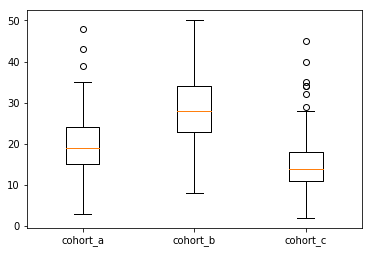

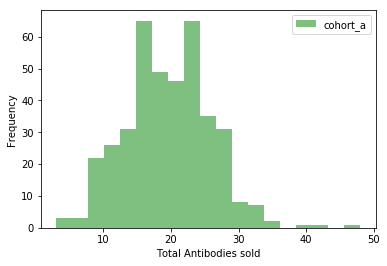

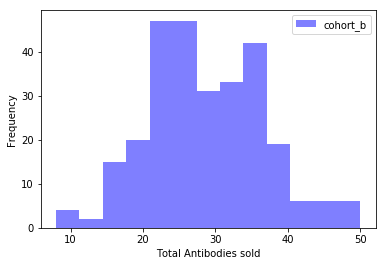

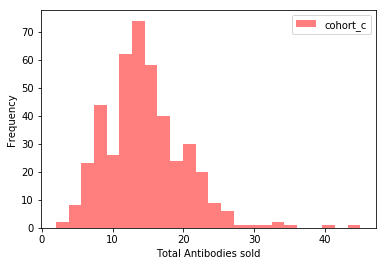

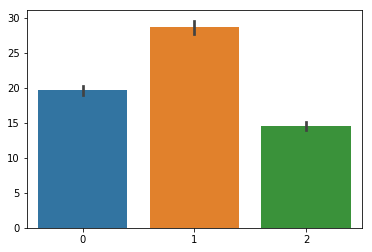

In [7]:
cohort_a = []
cohort_b = []
cohort_c = []

for index, row in dftotal.iterrows():
    if row['cohort'] == "a":
        cohort_a.append(row['total_antibodies_sold'])
    if row['cohort'] == "b":
        cohort_b.append(row['total_antibodies_sold'])
    if row['cohort'] == "c":
        cohort_c.append(row['total_antibodies_sold'])

print(stats.describe(cohort_a))
print(stats.describe(cohort_b))
print(stats.describe(cohort_c))

fig1, ax1 = plt.subplots()
ax1.boxplot([cohort_a, cohort_b, cohort_c], labels = ['cohort_a', 'cohort_b', 'cohort_c',])
plt.show()

plt.hist(cohort_a, bins='auto', alpha=0.5, label='cohort_a', color = "green")
plt.xlabel('Total Antibodies sold')
plt.ylabel('Frequency')
plt.legend()
plt.show() 

plt.hist(cohort_b, bins='auto', alpha=0.5, label='cohort_b', color = "blue")
plt.xlabel('Total Antibodies sold')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.hist(cohort_c, bins='auto', alpha=0.5, label='cohort_c', color = "red")
plt.xlabel('Total Antibodies sold')
plt.ylabel('Frequency')
plt.legend()
plt.show()

ax = sns.barplot(data = [cohort_a, cohort_b, cohort_c], ci=95)

From the box plots, it looks like there is an even spread of antibodies sold for all three cohorts.
The histograms indicate the distribution of antibodies sold to follow an almost normal distribution.
Since the error bars (corresponding to 95% Confidence Interval) do not look like they are overlapping, it looks like the difference in means between cohort could be significant. 

The null and alternative hypotheses can be stated as below: <br/>

    H0: The cohort means are same 
    HA: The cohort means are different 
    
For the above hypotheses and the data and type of experiment, let's chose a one-way ANOVA test to check for significance between the cohorts.

In order to run the ANOVA test, it is important to check for their assumptions

1) Measures are sampled independantly from each other <br />
2) Residuals follows a normal distribution <br />
3) There is homogenitiy in the measures' variances <br />

It can be assumed that the measures are unique and independant as they are from different users and each user doesn't affect the other

##### Performing one-way ANOVA

In [8]:
model = ols('total_antibodies_sold ~ cohort', data=dftotal).fit()
anova_table = sm.stats.anova_lm(model, typ=2)            
print(anova_table)

                sum_sq      df           F         PR(>F)
cohort    33674.496029     2.0  394.738684  4.413196e-130
Residual  47132.849639  1105.0         NaN            NaN


Setting statistic significance to being below 0.05, we see that the value is below this threshold. Hence there exists statistic significance amongst the cohorts and the difference in purchasing behaviour of cohorts are not due to chance. 

##### Performing post-hoc pair-wise comparison between cohorts <br />

In [9]:
pair_test = model.t_test_pairwise('cohort')
pair_test.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
b-a,9.038206,0.511023,17.686486,7.858582e-62,8.035520,10.040891,0.0,True
c-a,-5.047794,0.453866,-11.121780,2.601765e-27,-5.938329,-4.157258,0.0,True
c-b,-14.085999,0.501711,-28.075935,2.339451e-131,-15.070413,-13.101586,0.0,True


From the above table, there exists signifcant differences between all the cohorts

#### It can then be concluded that cohort B performed the best

(TODO) Make a statement with regard to whether the significance makes sense from a 'contextual' (e.g business, usability) perspective

##### Testing for normal distribution of residuals <br />

We run Shapiro-Wilke test to check if they follow a normal distribution

In [10]:
# TODO

If the value of p is non-significant, we can assume they follow a normal distribution. If not, we need to check if the distribution is log-normal or exponential or gamma.

##### Testing for homogenity of variances <br />

In [11]:
# TODO

### *Q1b: Can you identify any interesting patterns in the information provided or purchasing behavior of the cohorts? Please describe the hypotheses / research questions you analyze and any theories that could explain the patterns you observe.*

#### The first research question would be to analyse the purchase rate of each of the cohorts and see which of them performed better. Also by analysing them against a timeline, we can hypothesize any theories that might explain certain patterns of the purchase rate 

##### Merging the data <br />


In [12]:
dfretention = pd.merge(df1, df2, on=['userid'])
dfretention.drop([ 'has_first_name', 'has_last_name', 'has_verfied_email', 'has_phone', 'number_of_items_watched'], axis=1, inplace=True)
dfretention.head(5)

,userid,cohort,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11,week 12,week 13,week 14,week 15
0,1101,c,0,0,4,1,1,0,0,2,0,0,0,1,0,0,1
1,1105,a,6,5,3,4,4,2,0,0,1,0,3,3,0,0,1
2,1109,c,0,0,4,3,4,0,1,1,0,0,1,0,0,0,0
3,1118,a,0,2,3,5,0,0,0,2,1,0,3,3,0,0,0
4,1135,c,0,0,4,3,0,3,0,1,0,2,0,1,0,1,2


##### Forming a cohort dataframe <br />
In order to look at purchasing rate between cohorts, let's choose the metric of total weekly purchases made by all users in each cohort


In [13]:
total_weekly_cohort_a = dict.fromkeys(('week 1', 'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8', 'week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14', 'week 15'), 0)
total_weekly_cohort_b = dict.fromkeys(('week 1', 'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8', 'week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14', 'week 15'), 0)
total_weekly_cohort_c = dict.fromkeys(('week 1', 'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8', 'week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14', 'week 15'), 0)

for index, row in dfretention.iterrows():    
    if row['cohort'] == "a":
        for i in row.index: 
            if i in total_weekly_cohort_a.keys():
                total_weekly_cohort_a[i] = total_weekly_cohort_a[i] + row[i]
    if row['cohort'] == "b":
        for i in row.index:
            if i in total_weekly_cohort_a.keys():
                total_weekly_cohort_b[i] = total_weekly_cohort_b[i] + row[i]
    if row['cohort'] == "c":
        for i in row.index: 
            if i in total_weekly_cohort_a.keys():
                total_weekly_cohort_c[i] = total_weekly_cohort_c[i] + row[i]

In [14]:
# Forming a dataframe for a heatmap visualization
dfheat = pd.DataFrame([total_weekly_cohort_a, total_weekly_cohort_b, total_weekly_cohort_c])
dfheat = dfheat[['week 1', 'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8', 'week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14', 'week 15']]
dfheat.rename(index={0: 'cohort_a', 1: 'cohort_b', 2: 'cohort_c'}, inplace=True)
dfheat.head(5)

,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11,week 12,week 13,week 14,week 15
cohort_a,799,666,670,934,521,463,318,629,408,366,323,597,407,359,301
cohort_b,241,288,381,838,427,419,555,964,530,568,489,929,457,390,485
cohort_c,641,600,584,801,517,387,328,472,288,273,233,456,253,267,215


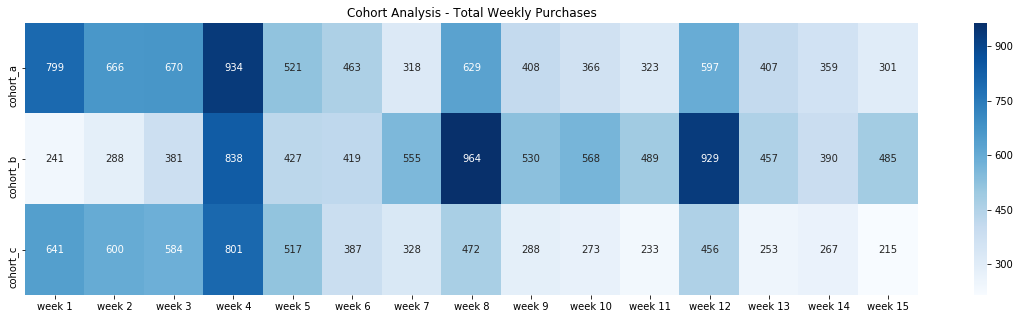

In [15]:
plt.figure(figsize = (20,5))
plt.title('Cohort Analysis - Total Weekly Purchases')
sns.heatmap(data = dfheat, annot = True, fmt='d', cmap = "Blues")
plt.show()

#### From the above visualization, it looks like for cohort A and C, there seems to be a general trend of falling purchases during the course of 15 weeks. There seems to be some sort of impetus to all cohorts at the beginning of week 4, 8 and 12. It could be that there was a specific marketing campaign or a common event to all cohorts. We can also arrive at a specific metric to quantify the temporal behaviour of rate of weekly purchases made by all users in a cohort in later analysis<br />

In [16]:
# Merging dataframe for subsequent research questions
dfuserdata = pd.merge(df1, df2, on=['userid'])
dfuserdata['total_antibodies_sold'] = dfuserdata[['week 1', 'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8', 'week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14', 'week 15']].sum(axis=1)
dfuserdata.drop(['userid', 'week 1', 'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8', 'week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14', 'week 15'], axis=1, inplace=True)
dfuserdata.head(5)

,cohort,has_first_name,has_last_name,has_verfied_email,has_phone,number_of_items_watched,total_antibodies_sold
0,c,False,True,False,False,0,10
1,a,True,True,False,True,1,32
2,c,True,True,True,False,10,14
3,a,True,False,False,False,0,19
4,c,True,True,True,False,5,17


#### The second research question would be around the 'completion' of user information given. It could be that different cohorts had different UI elements, such as flow of registration, and a certain cohort would have performed the best in terms of a user providing all their information (first name, last name and email). 

In [21]:
userdata_crosstabb = pd.crosstab(dfuserdata['cohort'], [dfuserdata['has_first_name'], dfuserdata['has_last_name'], dfuserdata['has_verfied_email']] , margins = False) 
print(userdata_crosstabb)

has_first_name    False                   True                   
has_last_name     False       True        False       True       
has_verfied_email False True  False True  False True  False True 
cohort                                                           
a                    10    15    67    63    19    20   109    93
b                     0    14     8    75     0    23     4   154
c                    15     8    97    43    26    11   173    61


In [22]:
# TODO: Finish analysis

Once we know the exact flow of registration, we can arrive at specific metrics for each stage of a user giving out their information in later analysis. 

#### The third research question would be to see if there is a correlation of number of items watched to the total number of antibodies purchased by each user in a cohort. This could mean that there is a better conversion rate between having an antibody marked relevant to it being purchased. 

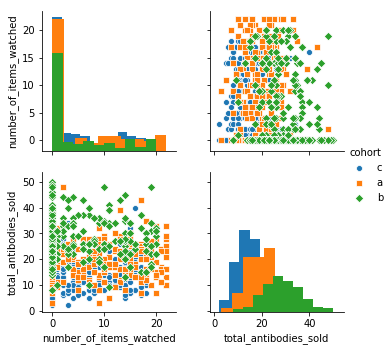

In [23]:
g = sns.pairplot(dfuserdata, diag_kind = 'hist', vars = ["number_of_items_watched", "total_antibodies_sold"], hue = "cohort", markers = ["o", "s", "D"])

In [24]:
print("Pearson coeffeciant of cohort_a: ", pearsonr(dfuserdata[dfuserdata['cohort']=='a']['number_of_items_watched'], dfuserdata[dfuserdata['cohort']=='a']['total_antibodies_sold'])[0])
print("Pearson coeffeciant of cohort_b: ", pearsonr(dfuserdata[dfuserdata['cohort']=='b']['number_of_items_watched'], dfuserdata[dfuserdata['cohort']=='b']['total_antibodies_sold'])[0])
print("Pearson coeffeciant of cohort_c: ", pearsonr(dfuserdata[dfuserdata['cohort']=='c']['number_of_items_watched'], dfuserdata[dfuserdata['cohort']=='c']['total_antibodies_sold'])[0])

Pearson coeffeciant of cohort_a:  0.0034276294496395168
Pearson coeffeciant of cohort_b:  -0.03998596828654133
Pearson coeffeciant of cohort_c:  0.013324692309025648


#### From the scatter plots and pearson coeffeciants, it looks like there seems to be no correlation between the number of items watched to total antibodies sold in each cohort